# Development imputing

In [1]:
import pandas as pd
from blocksnet.enums import LandUse

blocks = pd.read_pickle('blocks.pickle')
for lu in LandUse:
    blocks[lu.value] = blocks[lu.value].clip(lower=0, upper=1)
blocks = blocks[blocks.area > 0]

In [2]:
from blocksnet.relations import generate_adjacency_graph

graph = generate_adjacency_graph(blocks, 10)

2025-07-15 21:46:51.883 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:9 - Generating nodes
2025-07-15 21:46:51.888 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:14 - Generating edges
2025-07-15 21:46:54.727 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:37 - Adjacency graph successfully generated: 9312 nodes, 30110 edges


In [3]:
import torch
import torch.nn as nn
from torch_geometric.nn import GraphSAGE

class MultiScaleGNN(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.output_size = output_size
        self.graphsage = GraphSAGE(
            in_channels=input_size,
            hidden_channels=hidden_dim,
            num_layers=num_layers,
            out_channels=hidden_dim,
            dropout=dropout,
            act='relu',
            norm=nn.LayerNorm(hidden_dim),
            jk='cat'
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, output_size)
        )
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, *args, **kwargs):
        features = self.graphsage(x, edge_index)
        output = self.output_layer(features)
        return output

In [4]:
from sklearn.preprocessing import StandardScaler
from blocksnet.machine_learning.strategy.torch import TorchGraphImputationStrategy

strategy_params = {
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.2,
}

strategy = TorchGraphImputationStrategy(
    MultiScaleGNN, 
    strategy_params, 
    scalers={'x': StandardScaler(), 'y': StandardScaler()}
)

In [5]:
from blocksnet.preprocessing.imputing import DevelopmentImputer

imputer = DevelopmentImputer(strategy)

## Train

In [6]:
train_params = {
    'epochs': 5000,
    'optimizer_params': {
        "lr": 1e-4,
        "weight_decay": 1e-4
    },
}

train_losses, test_losses = imputer.train(blocks, graph, train_params=train_params)

Train loss: 0.17307 | Test loss: 0.18692: 100%|██████████| 5000/5000 [00:58<00:00, 85.36it/s]


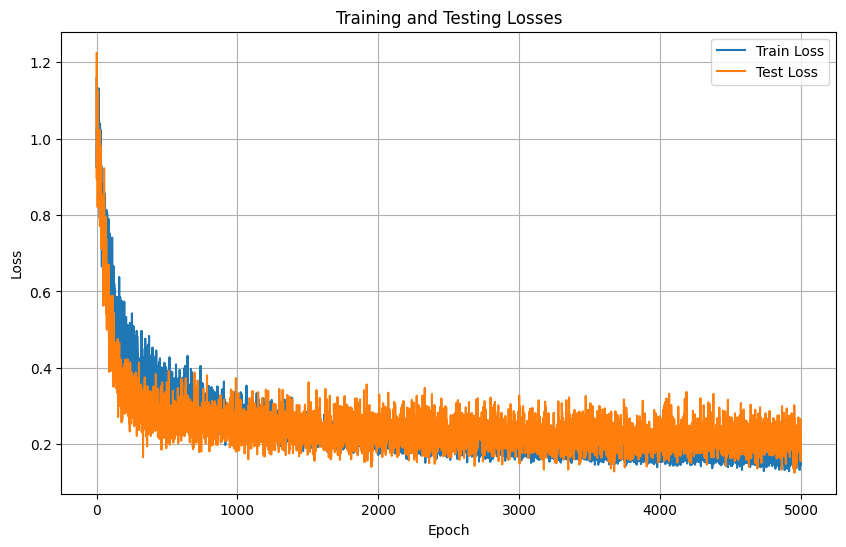

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()

## Validate

## Predict

In [8]:
block_id = 1217
neighbors = list(graph.neighbors(block_id))
land_use = LandUse.RESIDENTIAL

neighbors

[291, 292, 7315, 1172, 4998, 7312, 7316, 4999, 7313]

In [9]:
blocks.loc[block_id, ['build_floor_area', 'footprint_area', 'living_area']]

build_floor_area    85184.078863
footprint_area      21291.979269
living_area         39861.840942
Name: 1217, dtype: object

In [15]:
tmp = blocks.copy()
for lu in LandUse:
    tmp.loc[block_id, lu.value] = 0
tmp.loc[block_id, land_use.value] = 1

# for neighbor in neighbors:
#     tmp.loc[neighbor, ['build_floor_area', 'footprint_area', 'living_area']] = 0

In [16]:
tmp.loc[block_id, ['build_floor_area', 'footprint_area', 'living_area']] = imputer.run(tmp, graph, [block_id]).loc[block_id]

tmp.loc[block_id, ['build_floor_area', 'footprint_area', 'living_area']]

build_floor_area    87589.210938
footprint_area      22851.820312
living_area         40249.480469
Name: 1217, dtype: object